# Really good training pipeline for pytorch EfficientDet 

Hi everyone!

My name is Alex Shonenkov, I am DL/NLP/CV/TS research engineer. Especially I am in Love with NLP & DL.

Recently I have created kernel for this competition about Weighted Boxes Fusion:
- [WBF approach for ensemble](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble)


I hope it is useful for you, my friends! If you didn't read this kernel, don't forget to do it! :)


Today I would like to share really good training pipeline for this competition using SOTA [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/pdf/1911.09070.pdf)

## Main Idea
 
I read [all public kernels about EfficientDet in kaggle community](https://www.kaggle.com/search?q=efficientdet+in%3Anotebooks) and understand that kaggle don't have really good working public kernels with good score. Why? You can see below picture about COCO AP for different architectures, I think everyone should be able to use such a strong tools EfficientDet for own research, lets do it!

<img src='https://miro.medium.com/max/2400/0*ApAKUWtseHcvRV2U.png' width=400>   



## Dependencies and imports

In [1]:
#!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
#!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
#!pip install pycocotools

In [3]:
import sys
sys.path.insert(0, "../../efficientdet-pytorch")
sys.path.insert(0, "../../omegaconf")

import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [4]:
DATA_DIR = '/relevance2-nfs/chec/data/wheat'

In [5]:
marking = pd.read_csv(f'{DATA_DIR}/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

About data splitting you can read [here](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble):

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/relevance2-nfs/chec/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


## Albumentations

In [7]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

## Dataset

In [8]:
TRAIN_ROOT_PATH = f'{DATA_DIR}/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test:
            image, boxes = self.load_image_and_boxes(index)
        else:
            if random.random() > 0.5:
                image, boxes = self.load_mixup_image_and_boxes(index)
            else:
                image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        #print(records)
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        #print('>>>boxes:', boxes)
        #print('image shape:', image.shape)
        return image, boxes
    
    def load_mixup_image_and_boxes(self, index):
        img, boxes = self.load_image_and_boxes(index)
        rindex = random.randint(0, self.image_ids.shape[0] - 1)
        rimg, rboxes = self.load_image_and_boxes(rindex)
        
        mixup_image = (img + rimg)/2
        mixup_boxes = np.concatenate([boxes, rboxes], 0)
        #print(boxes.shape, rboxes.shape, mixup_boxes.shape)
        
        return mixup_image, mixup_boxes
        

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [9]:
def get_train_val_datasets(fold=0):
    train_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] != fold].index.values,
        marking=marking,
        transforms=get_train_transforms(),
        test=False,
    )

    validation_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] == fold].index.values,
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )
    return train_dataset, validation_dataset

In [10]:
#fold_number = 0
train_dataset, validation_datase = get_train_val_datasets(0)

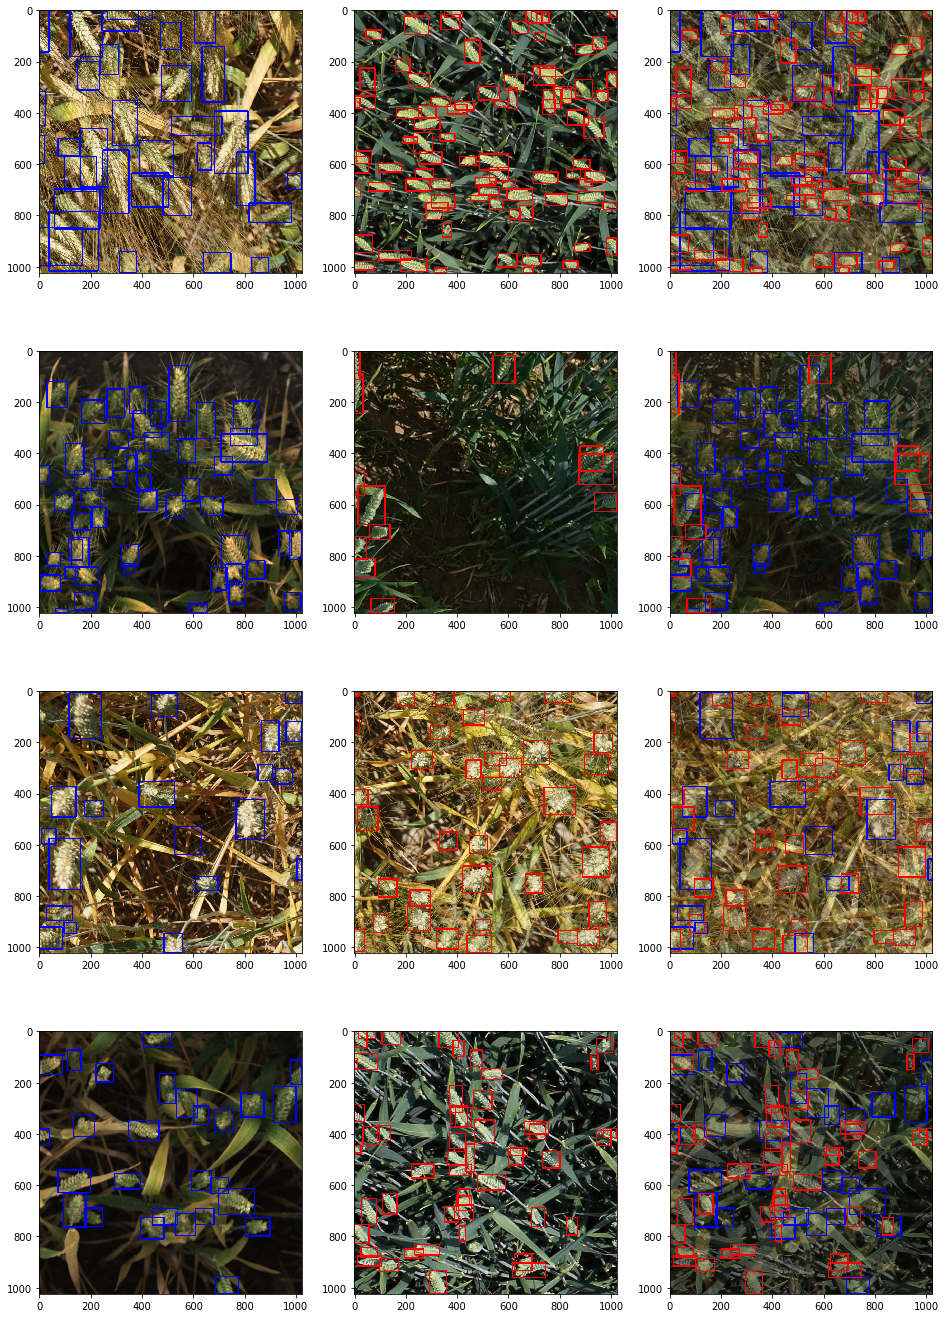

In [11]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    mixup_image = (image+r_image)/2

    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][1].imshow(r_image)
    ax[i][2].imshow(mixup_image)

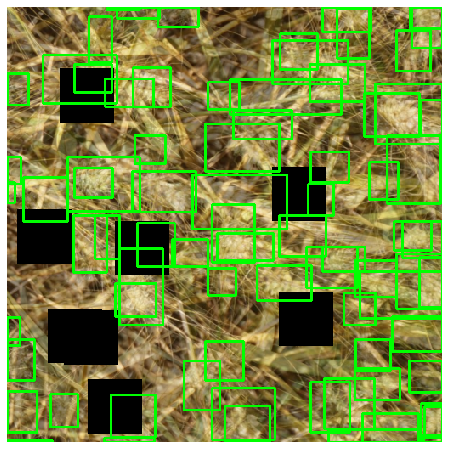

In [12]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

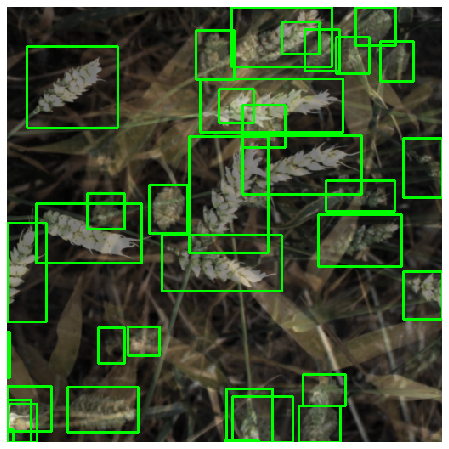

In [13]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

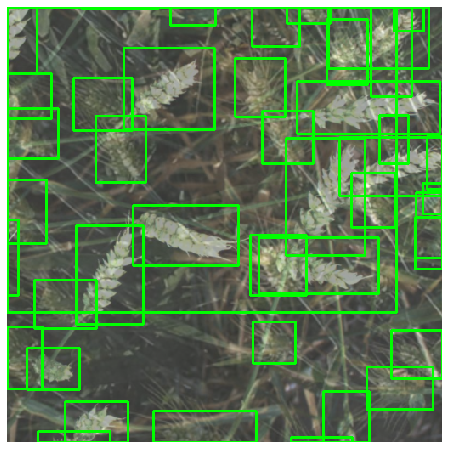

In [14]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

## Fitter

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
f'{1+2}'

'3'

In [24]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log_{self.config.ifold}.txt'
        self.best_summary_loss = 10**5
        self.model_file_best = f'{self.base_dir}/best-fold-{self.config.ifold}.pth'
        self.model_file_last = f'{self.base_dir}/last-fold-{self.config.ifold}.pth'

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        #self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=config.lr, momentum=0.9)
        lrs_config = config.lrs[config.lrs_name]
        self.scheduler = lrs_config['schedule_class'](self.optimizer, **lrs_config['schedule_params'])
        #self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def lrs_step(self, metrics):
        if self.config.lrs_name == 'plateau':
            self.scheduler.step(metrics)
        else:
            self.scheduler.step()

    def fit(self, train_loader, validation_loader):
        if self.load_best():
            summary_loss = self.validation(validation_loader)
            self.best_summary_loss = summary_loss.avg
            print(summary_loss.avg)
        
        if not isinstance(self.model.model, nn.DataParallel):
            self.model.model = nn.DataParallel(self.model.model)
        
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(self.model_file_last)

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f},\
                     best: {self.best_summary_loss}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(self.model_file_best)
                print('**saved**')
                
                #self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                #for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                #    os.remove(path)

            if self.config.validation_scheduler:
                #self.scheduler.step(metrics=summary_loss.avg)
                self.lrs_step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                #self.scheduler.step()
                self.lrs_step(summary_loss.avg)

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        model_state = self.model.model.module.state_dict() if isinstance(self.model.model, nn.DataParallel) else self.model.model.state_dict()
        torch.save({
            'model_state_dict': model_state,
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load_best(self):
        if os.path.exists(self.model_file_best):
            print(f'loading {self.model_file_best}...')
            self.load(self.model_file_best)
            return True
        else:
            print(f'{self.model_file_best} does not exist')
            return False

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [18]:
#os.path.exists('a')

In [25]:
class TrainGlobalConfig:
    num_workers = 24
    batch_size = 30
    n_epochs = 300 # n_epochs = 40
    lr = 0.005

    folder = 'ed5-mixup'
    ifold = 2

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    lrs_name = 'cosine' # plateau, cosine
    lrs = {
        'cosine': {
            'schedule_class': torch.optim.lr_scheduler.CosineAnnealingLR,
            'schedule_params': dict(
                T_max=12,
                eta_min=1e-5
            )
        },
        'plateau': {
            'schedule_class': torch.optim.lr_scheduler.ReduceLROnPlateau,
            'schedule_params': dict(
                mode='min',
                factor=0.5,
                patience=2,
                verbose=False, 
                threshold=0.0001,
                threshold_mode='abs',
                cooldown=0, 
                min_lr=1e-8,
                eps=2e-06
            )
        }
    }
    
    # --------------------
    #     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    #     scheduler_params = dict(
    #         max_lr=0.001,
    #         epochs=n_epochs,
    #         steps_per_epoch=int(len(train_dataset) / batch_size),
    #         pct_start=0.1,
    #         anneal_strategy='cos', 
    #         final_div_factor=10**5
    #     )


In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda')
    net.to(device)
    #net.cuda()
    #net.model = nn.DataParallel(net.model)
    
    train_dataset, validation_dataset = get_train_val_datasets(TrainGlobalConfig.ifold)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [21]:
#!pip install typing_extensions

In [27]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=True)
    checkpoint = torch.load('./pretrained/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    
    return DetBenchTrain(net, config)

net = get_net()

In [23]:
run_training()

Fitter prepared. Device is cuda
loading ./ed5-mixup/best-fold-2.pth...
0.36353382733133105mary_loss: 0.36325, time: 37.64138

2020-05-24T17:35:15.059861
LR: 0.0001
[RESULT]: Train. Epoch: 47, summary_loss: 0.45370, time: 201.50105
[RESULT]: Val. Epoch: 47, summary_loss: 0.37762,                     best: 0.36353382733133105, time: 26.98854

2020-05-24T17:39:07.325244
LR: 9.623203685930869e-05
[RESULT]: Train. Epoch: 48, summary_loss: 0.45250, time: 182.08693
[RESULT]: Val. Epoch: 48, summary_loss: 0.37271,                     best: 0.36353382733133105, time: 22.58498

2020-05-24T17:42:35.559581
LR: 8.55017856687341e-05
[RESULT]: Train. Epoch: 49, summary_loss: 0.45201, time: 178.30050
[RESULT]: Val. Epoch: 49, summary_loss: 0.36781,                     best: 0.36353382733133105, time: 22.97642

2020-05-24T17:46:00.120646
LR: 6.944282990207195e-05
[RESULT]: Train. Epoch: 50, summary_loss: 0.45256, time: 178.41719
[RESULT]: Val. Epoch: 50, summary_loss: 0.36851,                     best:

[RESULT]: Train. Epoch: 82, summary_loss: 0.44136, time: 177.90593
[RESULT]: Val. Epoch: 82, summary_loss: 0.36043,                     best: 0.3626321064101325, time: 23.04426
**saved**

2020-05-24T19:38:33.500384
LR: 5.0500000000000015e-05
[RESULT]: Train. Epoch: 83, summary_loss: 0.44168, time: 179.01760
[RESULT]: Val. Epoch: 83, summary_loss: 0.36186,                     best: 0.3604270080725352, time: 23.22483

2020-05-24T19:41:58.434702
LR: 3.155717009792806e-05
[RESULT]: Train. Epoch: 84, summary_loss: 0.43905, time: 177.93350
[RESULT]: Val. Epoch: 84, summary_loss: 0.36210,                     best: 0.3604270080725352, time: 23.31156

2020-05-24T19:45:22.352966
LR: 1.549821433126595e-05
[RESULT]: Train. Epoch: 85, summary_loss: 0.43895, time: 177.39980
[RESULT]: Val. Epoch: 85, summary_loss: 0.36212,                     best: 0.3604270080725352, time: 22.84191

2020-05-24T19:48:45.277090
LR: 4.767963140691323e-06
[RESULT]: Train. Epoch: 86, summary_loss: 0.43773, time: 179.0854

[RESULT]: Train. Epoch: 117, summary_loss: 0.43254, time: 179.09536
[RESULT]: Val. Epoch: 117, summary_loss: 0.36140,                     best: 0.3580569995774163, time: 22.95989

2020-05-24T21:38:01.163018
LR: 4.767963140691344e-06
[RESULT]: Train. Epoch: 118, summary_loss: 0.42916, time: 176.81575
[RESULT]: Val. Epoch: 118, summary_loss: 0.36021,                     best: 0.3580569995774163, time: 23.15995

2020-05-24T21:41:24.004080
LR: 1e-06
[RESULT]: Train. Epoch: 119, summary_loss: 0.43278, time: 179.58898
[RESULT]: Val. Epoch: 119, summary_loss: 0.35985,                     best: 0.3580569995774163, time: 23.09534

2020-05-24T21:44:49.448615
LR: 4.767963140691306e-06
[RESULT]: Train. Epoch: 120, summary_loss: 0.42871, time: 178.58695
[RESULT]: Val. Epoch: 120, summary_loss: 0.36006,                     best: 0.3580569995774163, time: 23.06848

2020-05-24T21:48:13.792512
LR: 1.549821433126608e-05
[RESULT]: Train. Epoch: 121, summary_loss: 0.43097, time: 178.25539
[RESULT]: Val. E

[RESULT]: Train. Epoch: 152, summary_loss: 0.42636, time: 179.63776
[RESULT]: Val. Epoch: 152, summary_loss: 0.35732,                     best: 0.35731662842962475, time: 23.33483

2020-05-24T23:37:36.323639
LR: 1.5498214331265833e-05
[RESULT]: Train. Epoch: 153, summary_loss: 0.42441, time: 180.27511
[RESULT]: Val. Epoch: 153, summary_loss: 0.35984,                     best: 0.35731662842962475, time: 23.21382

2020-05-24T23:41:02.449022
LR: 3.155717009792787e-05
[RESULT]: Train. Epoch: 154, summary_loss: 0.42639, time: 179.40817
[RESULT]: Val. Epoch: 154, summary_loss: 0.35911,                     best: 0.35731662842962475, time: 22.97373

2020-05-24T23:44:27.571751
LR: 5.049999999999968e-05
[RESULT]: Train. Epoch: 155, summary_loss: 0.42509, time: 179.79897
[RESULT]: Val. Epoch: 155, summary_loss: 0.36274,                     best: 0.35731662842962475, time: 23.38124

2020-05-24T23:47:53.506089
LR: 6.944282990207152e-05
[RESULT]: Train. Epoch: 156, summary_loss: 0.42674, time: 180.8

[RESULT]: Train. Epoch: 187, summary_loss: 0.42061, time: 177.91891
[RESULT]: Val. Epoch: 187, summary_loss: 0.36336,                     best: 0.35707055528958637, time: 22.87396

2020-05-25T01:37:11.182925
LR: 6.94428299020717e-05
[RESULT]: Train. Epoch: 188, summary_loss: 0.42115, time: 178.13494
[RESULT]: Val. Epoch: 188, summary_loss: 0.36164,                     best: 0.35707055528958637, time: 23.19775

2020-05-25T01:40:35.690179
LR: 8.550178566873411e-05
[RESULT]: Train. Epoch: 189, summary_loss: 0.42147, time: 178.59834
[RESULT]: Val. Epoch: 189, summary_loss: 0.36599,                     best: 0.35707055528958637, time: 22.97246

2020-05-25T01:44:00.011367
LR: 9.623203685930867e-05
[RESULT]: Train. Epoch: 190, summary_loss: 0.42420, time: 177.70375
[RESULT]: Val. Epoch: 190, summary_loss: 0.36441,                     best: 0.35707055528958637, time: 22.87903

2020-05-25T01:47:23.362449
LR: 9.999999999999998e-05
[RESULT]: Train. Epoch: 191, summary_loss: 0.42439, time: 178.460

[RESULT]: Train. Epoch: 222, summary_loss: 0.41748, time: 178.92598
[RESULT]: Val. Epoch: 222, summary_loss: 0.36724,                     best: 0.35707055528958637, time: 22.97384

2020-05-25T03:36:29.797051
LR: 0.00010000000000000015
[RESULT]: Train. Epoch: 223, summary_loss: 0.41894, time: 177.90962
[RESULT]: Val. Epoch: 223, summary_loss: 0.36406,                     best: 0.35707055528958637, time: 23.36546

2020-05-25T03:39:53.774626
LR: 9.623203685930879e-05
[RESULT]: Train. Epoch: 224, summary_loss: 0.42063, time: 180.31233
[RESULT]: Val. Epoch: 224, summary_loss: 0.36364,                     best: 0.35707055528958637, time: 23.14774

2020-05-25T03:43:19.913215
LR: 8.550178566873417e-05
[RESULT]: Train. Epoch: 225, summary_loss: 0.42090, time: 177.43526
[RESULT]: Val. Epoch: 225, summary_loss: 0.36197,                     best: 0.35707055528958637, time: 23.11975

2020-05-25T03:46:43.565522
LR: 6.944282990207202e-05
[RESULT]: Train. Epoch: 226, summary_loss: 0.41664, time: 177.0

[RESULT]: Train. Epoch: 257, summary_loss: 0.41271, time: 179.38304
[RESULT]: Val. Epoch: 257, summary_loss: 0.36304,                     best: 0.35707055528958637, time: 22.96531

2020-05-25T05:35:40.882497
LR: 6.944282990207224e-05
[RESULT]: Train. Epoch: 258, summary_loss: 0.41355, time: 179.30409
[RESULT]: Val. Epoch: 258, summary_loss: 0.36138,                     best: 0.35707055528958637, time: 23.15941

2020-05-25T05:39:06.081516
LR: 5.0500000000000286e-05
[RESULT]: Train. Epoch: 259, summary_loss: 0.40968, time: 177.73673
[RESULT]: Val. Epoch: 259, summary_loss: 0.35984,                     best: 0.35707055528958637, time: 23.48511

2020-05-25T05:42:29.960058
LR: 3.155717009792831e-05
[RESULT]: Train. Epoch: 260, summary_loss: 0.40982, time: 178.22339
[RESULT]: Val. Epoch: 260, summary_loss: 0.36142,                     best: 0.35707055528958637, time: 22.95955

2020-05-25T05:45:55.419708
LR: 1.5498214331266107e-05
[RESULT]: Train. Epoch: 261, summary_loss: 0.40756, time: 179.

[RESULT]: Train. Epoch: 292, summary_loss: 0.40504, time: 177.56245
[RESULT]: Val. Epoch: 292, summary_loss: 0.36259,                     best: 0.35707055528958637, time: 22.74696

2020-05-25T07:34:46.556304
LR: 1.5498214331266165e-05
[RESULT]: Train. Epoch: 293, summary_loss: 0.40144, time: 176.77833
[RESULT]: Val. Epoch: 293, summary_loss: 0.36198,                     best: 0.35707055528958637, time: 22.86704

2020-05-25T07:38:08.992201
LR: 4.7679631406914496e-06
[RESULT]: Train. Epoch: 294, summary_loss: 0.40148, time: 178.90021
[RESULT]: Val. Epoch: 294, summary_loss: 0.36263,                     best: 0.35707055528958637, time: 22.98997

2020-05-25T07:41:33.624579
LR: 1e-06
[RESULT]: Train. Epoch: 295, summary_loss: 0.40320, time: 177.82868
[RESULT]: Val. Epoch: 295, summary_loss: 0.36305,                     best: 0.35707055528958637, time: 22.77863

2020-05-25T07:44:56.916701
LR: 4.767963140691306e-06
[RESULT]: Train. Epoch: 296, summary_loss: 0.39997, time: 178.90620
[RESULT]: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/relevance2-nfs/chec/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-2f18cc448813>", line 1, in <module>
    run_training()
  File "<ipython-input-20-5bfacac5e398>", line 32, in run_training
    fitter.fit(train_loader, val_loader)
  File "<ipython-input-17-e8fa4f9d1a8f>", line 58, in fit
    summary_loss = self.train_one_epoch(train_loader)
  File "<ipython-input-17-e8fa4f9d1a8f>", line 129, in train_one_epoch
    loss, _, _ = self.model(images, boxes, labels)
  File "/relevance2-nfs/chec/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "../../efficientdet-pytorch/effdet/bench.py", line 86, in forward
    class_out, box_out = self.model(x)
  File "/relevance2-nfs/chec/anaconda3/lib/python3.7/site-packages/torch/nn/modules/modul

KeyboardInterrupt: 

In [ ]:
run_training()

Fitter prepared. Device is cuda
loading ./ed5-mixup/best-fold-2.pth...
0.35707055528958637mary_loss: 0.35723, time: 38.37911

2020-05-25T08:20:43.847667
LR: 0.005
[RESULT]: Train. Epoch: 171, summary_loss: 0.41946, time: 172.87594
[RESULT]: Val. Epoch: 171, summary_loss: 0.35685,                     best: 0.35707055528958637, time: 23.67634
**saved**

2020-05-25T08:24:04.401525
LR: 0.004914984936591225
[RESULT]: Train. Epoch: 172, summary_loss: 0.42165, time: 169.83853
[RESULT]: Val. Epoch: 172, summary_loss: 0.35739,                     best: 0.35685469839308, time: 23.70472

2020-05-25T08:27:20.013585
LR: 0.004665733382442175
[RESULT]: Train. Epoch: 173, summary_loss: 0.42146, time: 171.03533
[RESULT]: Val. Epoch: 173, summary_loss: 0.35778,                     best: 0.35685469839308, time: 23.47241

2020-05-25T08:30:36.610372
LR: 0.004269231419060436
[RESULT]: Train. Epoch: 174, summary_loss: 0.42069, time: 169.61692
[RESULT]: Val. Epoch: 174, summary_loss: 0.35809,                 

### Thank you for reading my kernel!

So, I have prepared good training SOTA-model baseline for you, my friends! I have used n_epochs = 40 and have got best checkpoint single model that gives 0.7176 LB. You can see [here](https://www.kaggle.com/shonenkov/inference-efficientdet) inference kernel.

Just recently I have started publishing my works, if you like this format of notebooks I would like continue to make kernels.